In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.sparse import csr_matrix

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
amt_handler = trainer.AmtTrainHandler()
profile_handler = trainer.AmtProfileHandler()
rank_handler = trainer.RankTopHandler()

In [3]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
amt_feats = loader.load_result('2021_12_06_amt_feats.joblib')

In [4]:
amt_handler.update_data(amt_feats)
amt_test = amt_handler.test.copy()
amt_test['dt'] = 25

amt_train = amt_handler.X.copy()
amt_train['dt'] = [23] * 500000 + [24] * 500000

ylabels = amt_handler.y.copy()

Start Update Data
Finished updating data


In [5]:
amt_train = amt_train.reset_index(drop=True)
amt_test = amt_test.reset_index(drop=True)

profile_handler.update_data(profile_feats)
amt_train = pd.merge(amt_train, profile_feats, on=['chid', 'dt'], how='left')
amt_test = pd.merge(amt_test, profile_feats, on=['chid', 'dt'], how='left')

amt_train = amt_train.drop(['chid', 'dt'], axis=1)
amt_test = amt_test.drop(['chid', 'dt'], axis=1)

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [6]:
# profile_handler.update_data(pd.concat([amt_train ,amt_test]).copy())
amt_train = profile_handler.transform(amt_train)    
amt_test = profile_handler.transform(amt_test)

In [7]:
# drop 1~18 non imp amt and cnt
non_imp_cates = l3 = [
    x for x in amt_handler.shop_cate if x not in amt_handler.ylabels
]
drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        amt_cate_col = "shop_{}_amt_{}".format(non_imp_cate, dt - 24)
        drop_feats.append(amt_cate_col)
amt_train = amt_train.drop(drop_feats, axis=1)
amt_test = amt_test.drop(drop_feats, axis=1)

In [8]:
# rank feats
rank_feats = loader.load_result('2021_12_17_rank_feats.joblib')
rank_handler.update_data(rank_feats)
rank_train = rank_handler.train.drop(['chid'], axis=1)
rank_test = rank_handler.test.drop(['chid'], axis=1)
rank_train = rank_train.reset_index(drop=True)
rank_test = rank_test.reset_index(drop=True)

Start Update Data
Start Processing train set
Start Processing test set
Finished updating data


In [9]:
amt_train = pd.concat([amt_train,rank_train], axis=1)
amt_test = pd.concat([amt_test, rank_test], axis=1)

In [10]:
from sklearn.model_selection import KFold
X = amt_train.copy()
y = ylabels.reset_index(drop=True).copy()
kf = KFold(n_splits=3, shuffle=True, random_state=16)
kf.get_n_splits(X)

3

In [1]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'regression',
    'metric': 'l2',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [12]:
profile_handler.cate_feats = profile_handler.cate_feats + [
    "how_many_cate_{}".format(dt - 24) for dt in range(2, 24)
] + ['how_many_cate_imp_{}'.format(dt - 24) for dt in range(2, 24)]

target_cols = ["top1_{}".format(dt - 24) for dt in range(2, 24)] + [
    "top2_{}".format(dt - 24) for dt in range(2, 24)
] + ['top3_{}'.format(dt - 24) for dt in range(2, 24)]
target_cols = target_cols + [
    "imp_top1_{}".format(dt - 24) for dt in range(2, 24)
] + ["imp_top2_{}".format(dt - 24) for dt in range(2, 24)
     ] + ["imp_top3_{}".format(dt - 24) for dt in range(2, 24)]

profile_handler.cate_feats = profile_handler.cate_feats + target_cols

# te = trainer.TargetEncoder(target_cols)

In [13]:
def get_int_trans(x):
    if x == 'other':
        return 49
    elif x == '-1':
        return 50
    else:
        return int(x)


for col in target_cols:
    X[col] = X[col].apply(get_int_trans)
    amt_test[col] = amt_test[col].apply(get_int_trans)

Training fold 1


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.96609e+07	valid_1's l2: 3.0752e+07
[100]	training's l2: 2.66325e+07	valid_1's l2: 2.80765e+07
[150]	training's l2: 2.50199e+07	valid_1's l2: 2.68423e+07
[200]	training's l2: 2.40325e+07	valid_1's l2: 2.62481e+07
[250]	training's l2: 2.33415e+07	valid_1's l2: 2.59479e+07
[300]	training's l2: 2.27937e+07	valid_1's l2: 2.57884e+07
[350]	training's l2: 2.23271e+07	valid_1's l2: 2.57022e+07
[400]	training's l2: 2.19131e+07	valid_1's l2: 2.5648e+07
[450]	training's l2: 2.15366e+07	valid_1's l2: 2.56111e+07
[500]	training's l2: 2.12062e+07	valid_1's l2: 2.55874e+07
[550]	training's l2: 2.08958e+07	valid_1's l2: 2.55695e+07
[600]	training's l2: 2.05991e+07	valid_1's l2: 2.55568e+07
[650]	training's l2: 2.02983e+07	valid_1's l2: 2.55506e+07
[700]	training's l2: 2.00256e+07	valid_1's l2: 2.55446e+07
[750]	training's l2: 1.97569e+07	valid_1's l2: 2.55403e+07
[800]	training's l2: 1.94949e+07	valid_1's l2: 2.55389e+

<Figure size 864x432 with 0 Axes>

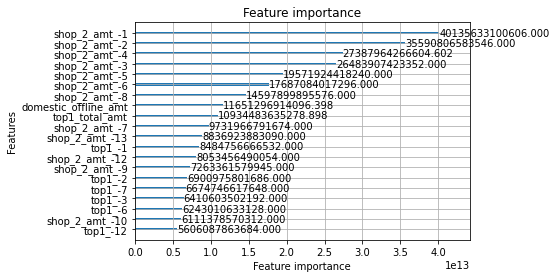

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.00706e+06	valid_1's l2: 7.07332e+06
[100]	training's l2: 6.31346e+06	valid_1's l2: 6.44909e+06
[150]	training's l2: 5.94727e+06	valid_1's l2: 6.15803e+06
[200]	training's l2: 5.72369e+06	valid_1's l2: 6.00735e+06
[250]	training's l2: 5.57631e+06	valid_1's l2: 5.93307e+06
[300]	training's l2: 5.4607e+06	valid_1's l2: 5.89424e+06
[350]	training's l2: 5.36558e+06	valid_1's l2: 5.8721e+06
[400]	training's l2: 5.27807e+06	valid_1's l2: 5.85827e+06
[450]	training's l2: 5.19979e+06	valid_1's l2: 5.85103e+06
[500]	training's l2: 5.12636e+06	valid_1's l2: 5.84494e+06
[550]	training's l2: 5.05643e+06	valid_1's l2: 5.84042e+06
[600]	training's l2: 4.99162e+06	valid_1's l2: 5.8376e+06
[650]	training's l2: 4.92747e+06	valid_1's l2: 5.83577e+06
[700]	training's l2: 4.86642e+06	valid_1's l2: 5.83382e+06
[750]	training's l2: 4.80402e+06	valid_1's l2: 5.83255e+06
[800]	training's l2: 4.74618e+06	valid_1's l2: 5.83115e+0

<Figure size 864x432 with 0 Axes>

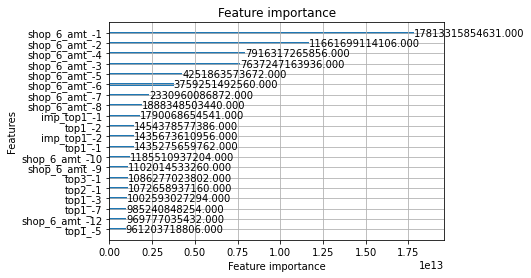

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.35551e+07	valid_1's l2: 2.38085e+07
[100]	training's l2: 2.04479e+07	valid_1's l2: 2.10576e+07
[150]	training's l2: 1.88602e+07	valid_1's l2: 1.98227e+07
[200]	training's l2: 1.79663e+07	valid_1's l2: 1.92782e+07
[250]	training's l2: 1.73521e+07	valid_1's l2: 1.89997e+07
[300]	training's l2: 1.68757e+07	valid_1's l2: 1.88489e+07
[350]	training's l2: 1.64823e+07	valid_1's l2: 1.87624e+07
[400]	training's l2: 1.61335e+07	valid_1's l2: 1.87098e+07
[450]	training's l2: 1.58084e+07	valid_1's l2: 1.86694e+07
[500]	training's l2: 1.55142e+07	valid_1's l2: 1.86438e+07
[550]	training's l2: 1.5228e+07	valid_1's l2: 1.86221e+07
[600]	training's l2: 1.49646e+07	valid_1's l2: 1.8608e+07
[650]	training's l2: 1.47215e+07	valid_1's l2: 1.85954e+07
[700]	training's l2: 1.44811e+07	valid_1's l2: 1.85842e+07
[750]	training's l2: 1.42516e+07	valid_1's l2: 1.85775e+07
[800]	training's l2: 1.40298e+07	valid_1's l2: 1.8571e+0

<Figure size 864x432 with 0 Axes>

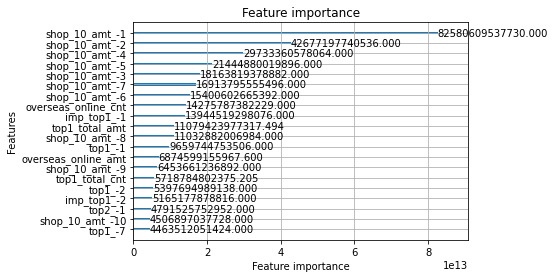

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.55833e+06	valid_1's l2: 9.78575e+06
[100]	training's l2: 8.68214e+06	valid_1's l2: 9.04869e+06
[150]	training's l2: 8.22481e+06	valid_1's l2: 8.72279e+06
[200]	training's l2: 7.93991e+06	valid_1's l2: 8.56519e+06
[250]	training's l2: 7.74364e+06	valid_1's l2: 8.4885e+06
[300]	training's l2: 7.58663e+06	valid_1's l2: 8.44383e+06
[350]	training's l2: 7.45284e+06	valid_1's l2: 8.42028e+06
[400]	training's l2: 7.33033e+06	valid_1's l2: 8.40686e+06
[450]	training's l2: 7.21637e+06	valid_1's l2: 8.3972e+06
[500]	training's l2: 7.10735e+06	valid_1's l2: 8.39047e+06
[550]	training's l2: 7.00709e+06	valid_1's l2: 8.38629e+06
[600]	training's l2: 6.90974e+06	valid_1's l2: 8.38188e+06
[650]	training's l2: 6.81488e+06	valid_1's l2: 8.37951e+06
[700]	training's l2: 6.72311e+06	valid_1's l2: 8.37665e+06
[750]	training's l2: 6.64179e+06	valid_1's l2: 8.37597e+06
[800]	training's l2: 6.56066e+06	valid_1's l2: 8.37447e+

<Figure size 864x432 with 0 Axes>

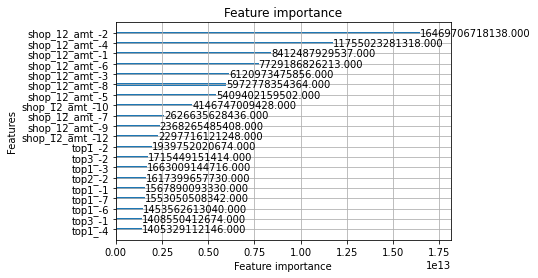

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.51508e+06	valid_1's l2: 3.58356e+06
[100]	training's l2: 2.81147e+06	valid_1's l2: 2.90595e+06
[150]	training's l2: 2.46124e+06	valid_1's l2: 2.58539e+06
[200]	training's l2: 2.27257e+06	valid_1's l2: 2.42925e+06
[250]	training's l2: 2.1366e+06	valid_1's l2: 2.3246e+06
[300]	training's l2: 2.04548e+06	valid_1's l2: 2.26609e+06
[350]	training's l2: 1.97971e+06	valid_1's l2: 2.23276e+06
[400]	training's l2: 1.91781e+06	valid_1's l2: 2.20155e+06
[450]	training's l2: 1.87029e+06	valid_1's l2: 2.18493e+06
[500]	training's l2: 1.82722e+06	valid_1's l2: 2.17158e+06
[550]	training's l2: 1.78469e+06	valid_1's l2: 2.15646e+06
[600]	training's l2: 1.74606e+06	valid_1's l2: 2.14542e+06
[650]	training's l2: 1.7105e+06	valid_1's l2: 2.13646e+06
[700]	training's l2: 1.67864e+06	valid_1's l2: 2.12984e+06
[750]	training's l2: 1.64859e+06	valid_1's l2: 2.12333e+06
[800]	training's l2: 1.62031e+06	valid_1's l2: 2.1179e+06

<Figure size 864x432 with 0 Axes>

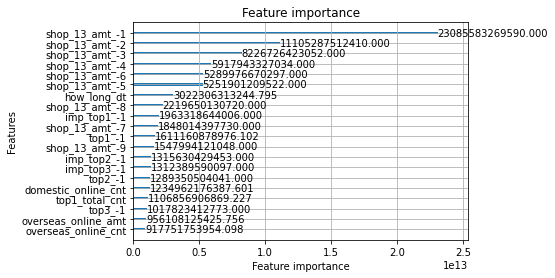

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.81196e+07	valid_1's l2: 1.863e+07
[100]	training's l2: 1.55119e+07	valid_1's l2: 1.62791e+07
[150]	training's l2: 1.42181e+07	valid_1's l2: 1.52425e+07
[200]	training's l2: 1.34892e+07	valid_1's l2: 1.47696e+07
[250]	training's l2: 1.30061e+07	valid_1's l2: 1.45389e+07
[300]	training's l2: 1.26362e+07	valid_1's l2: 1.44146e+07
[350]	training's l2: 1.23355e+07	valid_1's l2: 1.43481e+07
[400]	training's l2: 1.20689e+07	valid_1's l2: 1.43091e+07
[450]	training's l2: 1.18278e+07	valid_1's l2: 1.4281e+07
[500]	training's l2: 1.16113e+07	valid_1's l2: 1.4263e+07
[550]	training's l2: 1.14103e+07	valid_1's l2: 1.42495e+07
[600]	training's l2: 1.12305e+07	valid_1's l2: 1.42381e+07
[650]	training's l2: 1.10525e+07	valid_1's l2: 1.42298e+07
[700]	training's l2: 1.08955e+07	valid_1's l2: 1.42237e+07
[750]	training's l2: 1.0729e+07	valid_1's l2: 1.42177e+07
[800]	training's l2: 1.05748e+07	valid_1's l2: 1.42141e+07


<Figure size 864x432 with 0 Axes>

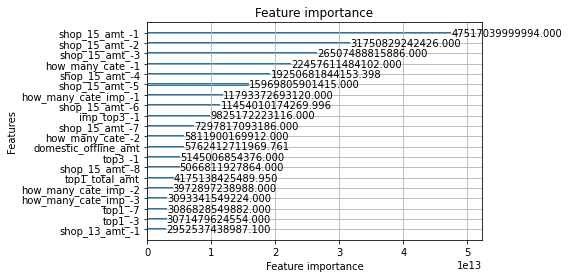

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.78939e+06	valid_1's l2: 8.03681e+06
[100]	training's l2: 7.32014e+06	valid_1's l2: 7.68533e+06
[150]	training's l2: 7.02669e+06	valid_1's l2: 7.50375e+06
[200]	training's l2: 6.81843e+06	valid_1's l2: 7.40542e+06
[250]	training's l2: 6.65714e+06	valid_1's l2: 7.35129e+06
[300]	training's l2: 6.52131e+06	valid_1's l2: 7.31738e+06
[350]	training's l2: 6.40533e+06	valid_1's l2: 7.29758e+06
[400]	training's l2: 6.29578e+06	valid_1's l2: 7.2858e+06
[450]	training's l2: 6.19624e+06	valid_1's l2: 7.27727e+06
[500]	training's l2: 6.10686e+06	valid_1's l2: 7.27236e+06
[550]	training's l2: 6.02002e+06	valid_1's l2: 7.2688e+06
[600]	training's l2: 5.93655e+06	valid_1's l2: 7.26626e+06
[650]	training's l2: 5.85703e+06	valid_1's l2: 7.26489e+06
[700]	training's l2: 5.77882e+06	valid_1's l2: 7.26365e+06
[750]	training's l2: 5.70474e+06	valid_1's l2: 7.2632e+06
[800]	training's l2: 5.63276e+06	valid_1's l2: 7.26254e+0

<Figure size 864x432 with 0 Axes>

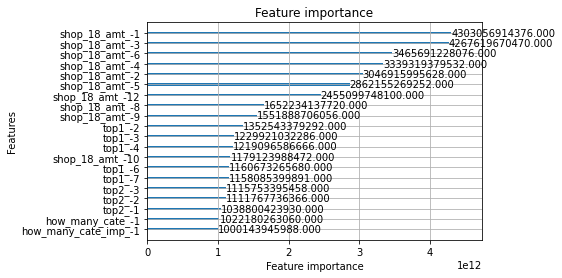

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.42769e+07	valid_1's l2: 1.43948e+07
[100]	training's l2: 1.3364e+07	valid_1's l2: 1.37431e+07
[150]	training's l2: 1.27808e+07	valid_1's l2: 1.34094e+07
[200]	training's l2: 1.23704e+07	valid_1's l2: 1.32402e+07
[250]	training's l2: 1.20503e+07	valid_1's l2: 1.31492e+07
[300]	training's l2: 1.17788e+07	valid_1's l2: 1.30986e+07
[350]	training's l2: 1.15356e+07	valid_1's l2: 1.30696e+07
[400]	training's l2: 1.13159e+07	valid_1's l2: 1.30519e+07
[450]	training's l2: 1.11148e+07	valid_1's l2: 1.30402e+07
[500]	training's l2: 1.09277e+07	valid_1's l2: 1.30317e+07
[550]	training's l2: 1.07543e+07	valid_1's l2: 1.30287e+07
[600]	training's l2: 1.05823e+07	valid_1's l2: 1.30251e+07
[650]	training's l2: 1.04196e+07	valid_1's l2: 1.30236e+07
[700]	training's l2: 1.02731e+07	valid_1's l2: 1.30228e+07
[750]	training's l2: 1.01263e+07	valid_1's l2: 1.30222e+07
[800]	training's l2: 9.98858e+06	valid_1's l2: 1.30226e

<Figure size 864x432 with 0 Axes>

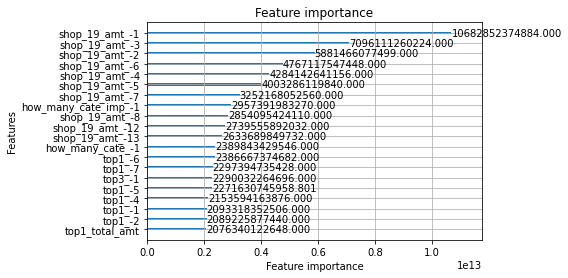

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.32385e+06	valid_1's l2: 8.75602e+06
[100]	training's l2: 7.98558e+06	valid_1's l2: 8.55222e+06
[150]	training's l2: 7.74513e+06	valid_1's l2: 8.44352e+06
[200]	training's l2: 7.56003e+06	valid_1's l2: 8.3869e+06
[250]	training's l2: 7.40813e+06	valid_1's l2: 8.3547e+06
[300]	training's l2: 7.27401e+06	valid_1's l2: 8.33598e+06
[350]	training's l2: 7.14956e+06	valid_1's l2: 8.32391e+06
[400]	training's l2: 7.03545e+06	valid_1's l2: 8.3161e+06
[450]	training's l2: 6.9256e+06	valid_1's l2: 8.31104e+06
[500]	training's l2: 6.82435e+06	valid_1's l2: 8.30672e+06
[550]	training's l2: 6.7274e+06	valid_1's l2: 8.30433e+06
[600]	training's l2: 6.636e+06	valid_1's l2: 8.30316e+06
[650]	training's l2: 6.54599e+06	valid_1's l2: 8.30194e+06
[700]	training's l2: 6.46095e+06	valid_1's l2: 8.30113e+06
[750]	training's l2: 6.3782e+06	valid_1's l2: 8.30124e+06
[800]	training's l2: 6.29079e+06	valid_1's l2: 8.30121e+06
Ear

<Figure size 864x432 with 0 Axes>

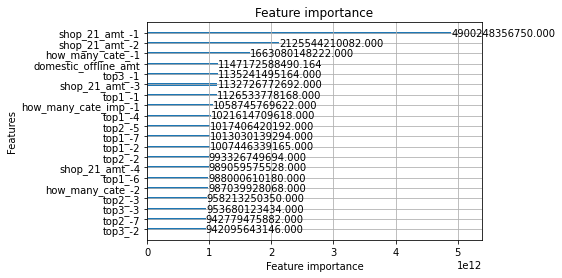

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.57844e+06	valid_1's l2: 2.65718e+06
[100]	training's l2: 2.35513e+06	valid_1's l2: 2.46637e+06
[150]	training's l2: 2.23151e+06	valid_1's l2: 2.37478e+06
[200]	training's l2: 2.15235e+06	valid_1's l2: 2.32748e+06
[250]	training's l2: 2.0955e+06	valid_1's l2: 2.30274e+06
[300]	training's l2: 2.05037e+06	valid_1's l2: 2.28914e+06
[350]	training's l2: 2.01095e+06	valid_1's l2: 2.28087e+06
[400]	training's l2: 1.9777e+06	valid_1's l2: 2.27638e+06
[450]	training's l2: 1.94697e+06	valid_1's l2: 2.27364e+06
[500]	training's l2: 1.91866e+06	valid_1's l2: 2.27184e+06
[550]	training's l2: 1.89239e+06	valid_1's l2: 2.27076e+06
[600]	training's l2: 1.8679e+06	valid_1's l2: 2.2702e+06
[650]	training's l2: 1.84444e+06	valid_1's l2: 2.26981e+06
[700]	training's l2: 1.82127e+06	valid_1's l2: 2.26946e+06
[750]	training's l2: 1.80061e+06	valid_1's l2: 2.26959e+06
Early stopping, best iteration is:
[695]	training's l2: 1.

<Figure size 864x432 with 0 Axes>

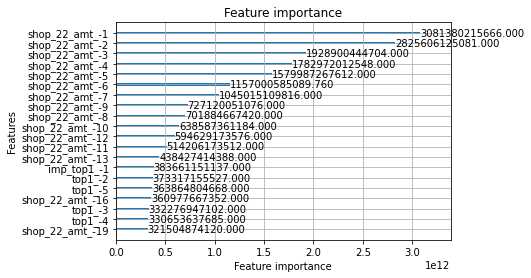

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.16818e+06	valid_1's l2: 4.11079e+06
[100]	training's l2: 3.83802e+06	valid_1's l2: 3.85183e+06
[150]	training's l2: 3.64101e+06	valid_1's l2: 3.72131e+06
[200]	training's l2: 3.51103e+06	valid_1's l2: 3.65198e+06
[250]	training's l2: 3.41562e+06	valid_1's l2: 3.61396e+06
[300]	training's l2: 3.33859e+06	valid_1's l2: 3.59346e+06
[350]	training's l2: 3.27265e+06	valid_1's l2: 3.58134e+06
[400]	training's l2: 3.2139e+06	valid_1's l2: 3.57479e+06
[450]	training's l2: 3.15906e+06	valid_1's l2: 3.5703e+06
[500]	training's l2: 3.10809e+06	valid_1's l2: 3.56731e+06
[550]	training's l2: 3.05922e+06	valid_1's l2: 3.56535e+06
[600]	training's l2: 3.0138e+06	valid_1's l2: 3.56386e+06
[650]	training's l2: 2.97097e+06	valid_1's l2: 3.56273e+06
[700]	training's l2: 2.92861e+06	valid_1's l2: 3.56228e+06
[750]	training's l2: 2.8865e+06	valid_1's l2: 3.5621e+06
[800]	training's l2: 2.84608e+06	valid_1's l2: 3.56216e+06


<Figure size 864x432 with 0 Axes>

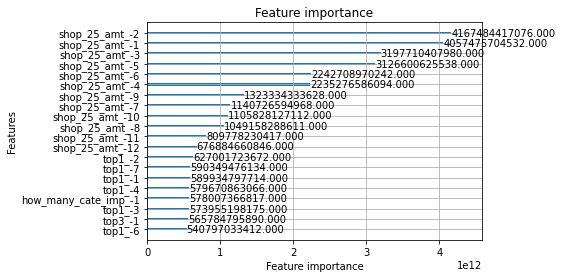

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.1326e+07	valid_1's l2: 1.18992e+07
[100]	training's l2: 1.08443e+07	valid_1's l2: 1.15612e+07
[150]	training's l2: 1.05417e+07	valid_1's l2: 1.13975e+07
[200]	training's l2: 1.03108e+07	valid_1's l2: 1.13028e+07
[250]	training's l2: 1.01213e+07	valid_1's l2: 1.12468e+07
[300]	training's l2: 9.95858e+06	valid_1's l2: 1.12171e+07
[350]	training's l2: 9.80784e+06	valid_1's l2: 1.11991e+07
[400]	training's l2: 9.67017e+06	valid_1's l2: 1.11872e+07
[450]	training's l2: 9.54169e+06	valid_1's l2: 1.1179e+07
[500]	training's l2: 9.41683e+06	valid_1's l2: 1.11742e+07
[550]	training's l2: 9.29905e+06	valid_1's l2: 1.11696e+07
[600]	training's l2: 9.18365e+06	valid_1's l2: 1.11664e+07
[650]	training's l2: 9.07254e+06	valid_1's l2: 1.11634e+07
[700]	training's l2: 8.96174e+06	valid_1's l2: 1.11622e+07
[750]	training's l2: 8.85598e+06	valid_1's l2: 1.11617e+07
[800]	training's l2: 8.75986e+06	valid_1's l2: 1.11614e+

<Figure size 864x432 with 0 Axes>

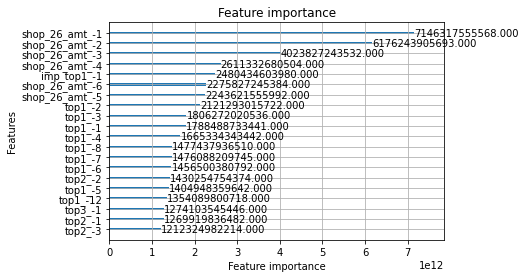

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.40254e+06	valid_1's l2: 8.33446e+06
[100]	training's l2: 6.47755e+06	valid_1's l2: 6.49646e+06
[150]	training's l2: 5.5755e+06	valid_1's l2: 5.68269e+06
[200]	training's l2: 5.11444e+06	valid_1's l2: 5.30924e+06
[250]	training's l2: 4.85788e+06	valid_1's l2: 5.14035e+06
[300]	training's l2: 4.69449e+06	valid_1's l2: 5.0637e+06
[350]	training's l2: 4.56956e+06	valid_1's l2: 5.024e+06
[400]	training's l2: 4.46182e+06	valid_1's l2: 4.99749e+06
[450]	training's l2: 4.36469e+06	valid_1's l2: 4.97899e+06
[500]	training's l2: 4.27986e+06	valid_1's l2: 4.96769e+06
[550]	training's l2: 4.20126e+06	valid_1's l2: 4.96072e+06
[600]	training's l2: 4.12835e+06	valid_1's l2: 4.95705e+06
[650]	training's l2: 4.05975e+06	valid_1's l2: 4.95392e+06
[700]	training's l2: 3.98989e+06	valid_1's l2: 4.94933e+06
[750]	training's l2: 3.92445e+06	valid_1's l2: 4.9469e+06
[800]	training's l2: 3.86309e+06	valid_1's l2: 4.94507e+06


<Figure size 864x432 with 0 Axes>

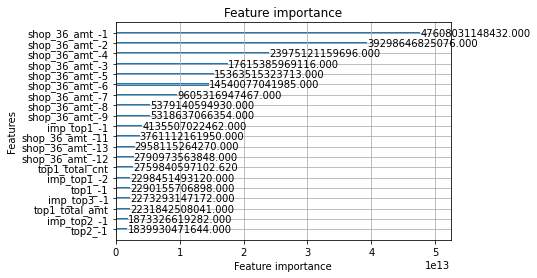

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.46201e+07	valid_1's l2: 2.47827e+07
[100]	training's l2: 2.0506e+07	valid_1's l2: 2.09443e+07
[150]	training's l2: 1.85863e+07	valid_1's l2: 1.93098e+07
[200]	training's l2: 1.75537e+07	valid_1's l2: 1.85662e+07
[250]	training's l2: 1.69338e+07	valid_1's l2: 1.82374e+07
[300]	training's l2: 1.64876e+07	valid_1's l2: 1.80746e+07
[350]	training's l2: 1.61256e+07	valid_1's l2: 1.79861e+07
[400]	training's l2: 1.58109e+07	valid_1's l2: 1.79365e+07
[450]	training's l2: 1.55295e+07	valid_1's l2: 1.79071e+07
[500]	training's l2: 1.52677e+07	valid_1's l2: 1.78864e+07
[550]	training's l2: 1.50201e+07	valid_1's l2: 1.78688e+07
[600]	training's l2: 1.47903e+07	valid_1's l2: 1.78583e+07
[650]	training's l2: 1.45693e+07	valid_1's l2: 1.78479e+07
[700]	training's l2: 1.43645e+07	valid_1's l2: 1.78414e+07
[750]	training's l2: 1.41624e+07	valid_1's l2: 1.78371e+07
[800]	training's l2: 1.39735e+07	valid_1's l2: 1.78325e

<Figure size 864x432 with 0 Axes>

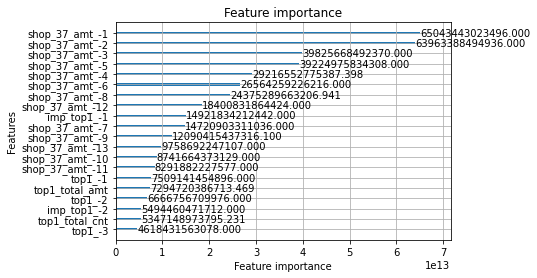

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.03446e+07	valid_1's l2: 1.06254e+07
[100]	training's l2: 9.82488e+06	valid_1's l2: 1.02746e+07
[150]	training's l2: 9.47866e+06	valid_1's l2: 1.00946e+07
[200]	training's l2: 9.22101e+06	valid_1's l2: 9.99655e+06
[250]	training's l2: 9.01395e+06	valid_1's l2: 9.93809e+06
[300]	training's l2: 8.83763e+06	valid_1's l2: 9.90277e+06
[350]	training's l2: 8.68305e+06	valid_1's l2: 9.88103e+06
[400]	training's l2: 8.54985e+06	valid_1's l2: 9.86794e+06
[450]	training's l2: 8.42561e+06	valid_1's l2: 9.85951e+06
[500]	training's l2: 8.31102e+06	valid_1's l2: 9.85362e+06
[550]	training's l2: 8.20148e+06	valid_1's l2: 9.8495e+06
[600]	training's l2: 8.09382e+06	valid_1's l2: 9.84801e+06
[650]	training's l2: 7.99268e+06	valid_1's l2: 9.847e+06
[700]	training's l2: 7.89226e+06	valid_1's l2: 9.84661e+06
[750]	training's l2: 7.79888e+06	valid_1's l2: 9.8463e+06
[800]	training's l2: 7.70962e+06	valid_1's l2: 9.84532e+06

<Figure size 864x432 with 0 Axes>

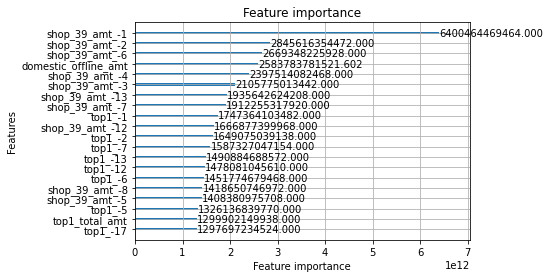

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.17038e+06	valid_1's l2: 9.25635e+06
[100]	training's l2: 7.65609e+06	valid_1's l2: 7.86519e+06
[150]	training's l2: 6.93926e+06	valid_1's l2: 7.26641e+06
[200]	training's l2: 6.54056e+06	valid_1's l2: 6.98594e+06
[250]	training's l2: 6.29676e+06	valid_1's l2: 6.85606e+06
[300]	training's l2: 6.11058e+06	valid_1's l2: 6.78331e+06
[350]	training's l2: 5.9647e+06	valid_1's l2: 6.74542e+06
[400]	training's l2: 5.83782e+06	valid_1's l2: 6.72431e+06
[450]	training's l2: 5.72331e+06	valid_1's l2: 6.71149e+06
[500]	training's l2: 5.6174e+06	valid_1's l2: 6.70168e+06
[550]	training's l2: 5.51587e+06	valid_1's l2: 6.69499e+06
[600]	training's l2: 5.42337e+06	valid_1's l2: 6.69101e+06
[650]	training's l2: 5.33211e+06	valid_1's l2: 6.68695e+06
[700]	training's l2: 5.25009e+06	valid_1's l2: 6.68501e+06
[750]	training's l2: 5.16866e+06	valid_1's l2: 6.68239e+06
[800]	training's l2: 5.09022e+06	valid_1's l2: 6.68034e+

<Figure size 864x432 with 0 Axes>

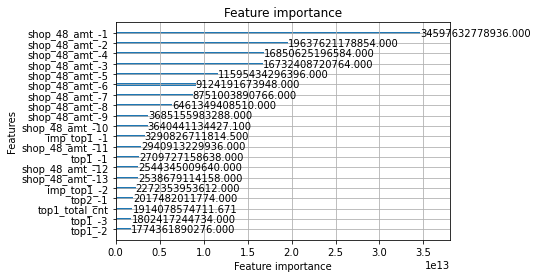

Training fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.9949e+07	valid_1's l2: 3.02268e+07
[100]	training's l2: 2.68803e+07	valid_1's l2: 2.76004e+07
[150]	training's l2: 2.52384e+07	valid_1's l2: 2.64005e+07
[200]	training's l2: 2.42262e+07	valid_1's l2: 2.58295e+07
[250]	training's l2: 2.352e+07	valid_1's l2: 2.55465e+07
[300]	training's l2: 2.29718e+07	valid_1's l2: 2.5404e+07
[350]	training's l2: 2.25125e+07	valid_1's l2: 2.53225e+07
[400]	training's l2: 2.2104e+07	valid_1's l2: 2.52734e+07
[450]	training's l2: 2.17258e+07	valid_1's l2: 2.52443e+07
[500]	training's l2: 2.138e+07	valid_1's l2: 2.52242e+07
[550]	training's l2: 2.10577e+07	valid_1's l2: 2.52089e+07
[600]	training's l2: 2.07463e+07	valid_1's l2: 2.51988e+07
[650]	training's l2: 2.04593e+07	valid_1's l2: 2.51935e+07
[700]	training's l2: 2.01799e+07	valid_1's l2: 2.51892e+07
[750]	training's l2: 1.99091e+07	valid_1's l2: 2.51869e+07
[800]	training's l2: 1.96512e+07	valid_1's l2

<Figure size 864x432 with 0 Axes>

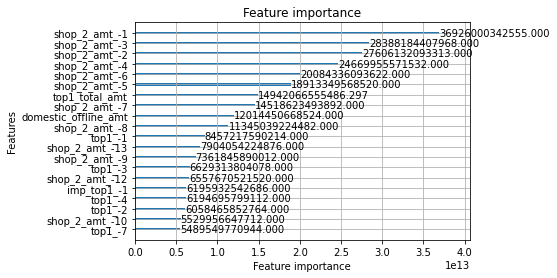

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.03655e+06	valid_1's l2: 7.17073e+06
[100]	training's l2: 6.30342e+06	valid_1's l2: 6.51047e+06
[150]	training's l2: 5.91958e+06	valid_1's l2: 6.20264e+06
[200]	training's l2: 5.69726e+06	valid_1's l2: 6.05629e+06
[250]	training's l2: 5.55263e+06	valid_1's l2: 5.98742e+06
[300]	training's l2: 5.43986e+06	valid_1's l2: 5.95029e+06
[350]	training's l2: 5.34412e+06	valid_1's l2: 5.9293e+06
[400]	training's l2: 5.26013e+06	valid_1's l2: 5.91678e+06
[450]	training's l2: 5.18111e+06	valid_1's l2: 5.90866e+06
[500]	training's l2: 5.10882e+06	valid_1's l2: 5.90159e+06
[550]	training's l2: 5.03734e+06	valid_1's l2: 5.8986e+06
[600]	training's l2: 4.96747e+06	valid_1's l2: 5.89591e+06
[650]	training's l2: 4.90345e+06	valid_1's l2: 5.89466e+06
[700]	training's l2: 4.84396e+06	valid_1's l2: 5.89344e+06
[750]	training's l2: 4.78266e+06	valid_1's l2: 5.89226e+06
[800]	training's l2: 4.72512e+06	valid_1's l2: 5.89175e+

<Figure size 864x432 with 0 Axes>

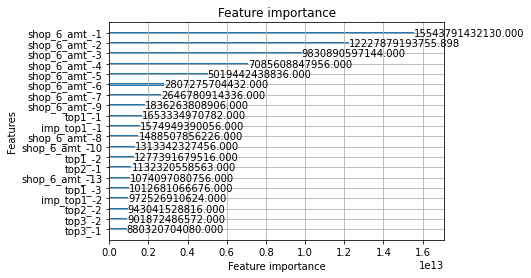

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.3687e+07	valid_1's l2: 2.41762e+07
[100]	training's l2: 2.0537e+07	valid_1's l2: 2.13078e+07
[150]	training's l2: 1.88979e+07	valid_1's l2: 1.99689e+07
[200]	training's l2: 1.79981e+07	valid_1's l2: 1.93909e+07
[250]	training's l2: 1.73638e+07	valid_1's l2: 1.90699e+07
[300]	training's l2: 1.68923e+07	valid_1's l2: 1.89135e+07
[350]	training's l2: 1.64886e+07	valid_1's l2: 1.88133e+07
[400]	training's l2: 1.61377e+07	valid_1's l2: 1.87544e+07
[450]	training's l2: 1.58158e+07	valid_1's l2: 1.87152e+07
[500]	training's l2: 1.55069e+07	valid_1's l2: 1.86872e+07
[550]	training's l2: 1.52306e+07	valid_1's l2: 1.86658e+07
[600]	training's l2: 1.49638e+07	valid_1's l2: 1.86495e+07
[650]	training's l2: 1.47085e+07	valid_1's l2: 1.86352e+07
[700]	training's l2: 1.4469e+07	valid_1's l2: 1.86259e+07
[750]	training's l2: 1.42362e+07	valid_1's l2: 1.86175e+07
[800]	training's l2: 1.40175e+07	valid_1's l2: 1.8612e+07

<Figure size 864x432 with 0 Axes>

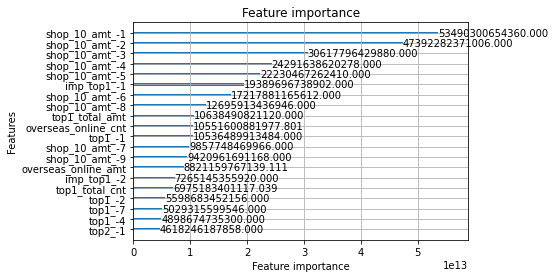

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.55327e+06	valid_1's l2: 9.82239e+06
[100]	training's l2: 8.68268e+06	valid_1's l2: 9.07102e+06
[150]	training's l2: 8.21909e+06	valid_1's l2: 8.72928e+06
[200]	training's l2: 7.93234e+06	valid_1's l2: 8.56315e+06
[250]	training's l2: 7.73731e+06	valid_1's l2: 8.48637e+06
[300]	training's l2: 7.57754e+06	valid_1's l2: 8.44179e+06
[350]	training's l2: 7.44567e+06	valid_1's l2: 8.41893e+06
[400]	training's l2: 7.32347e+06	valid_1's l2: 8.40498e+06
[450]	training's l2: 7.20869e+06	valid_1's l2: 8.39522e+06
[500]	training's l2: 7.10132e+06	valid_1's l2: 8.38891e+06
[550]	training's l2: 6.99758e+06	valid_1's l2: 8.3831e+06
[600]	training's l2: 6.90092e+06	valid_1's l2: 8.37963e+06
[650]	training's l2: 6.80905e+06	valid_1's l2: 8.37633e+06
[700]	training's l2: 6.71907e+06	valid_1's l2: 8.37457e+06
[750]	training's l2: 6.63262e+06	valid_1's l2: 8.37281e+06
[800]	training's l2: 6.5529e+06	valid_1's l2: 8.37177e+

<Figure size 864x432 with 0 Axes>

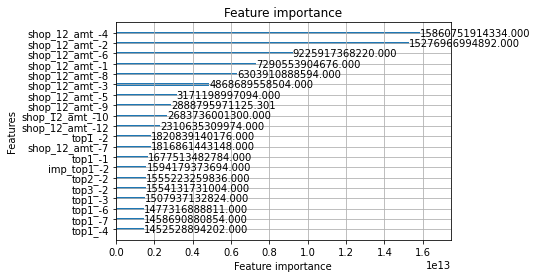

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.53012e+06	valid_1's l2: 3.56765e+06
[100]	training's l2: 2.84369e+06	valid_1's l2: 2.90853e+06
[150]	training's l2: 2.47023e+06	valid_1's l2: 2.56682e+06
[200]	training's l2: 2.26026e+06	valid_1's l2: 2.39203e+06
[250]	training's l2: 2.12907e+06	valid_1's l2: 2.29578e+06
[300]	training's l2: 2.03727e+06	valid_1's l2: 2.23883e+06
[350]	training's l2: 1.96909e+06	valid_1's l2: 2.2043e+06
[400]	training's l2: 1.91092e+06	valid_1's l2: 2.17893e+06
[450]	training's l2: 1.86194e+06	valid_1's l2: 2.16168e+06
[500]	training's l2: 1.81774e+06	valid_1's l2: 2.14856e+06
[550]	training's l2: 1.78023e+06	valid_1's l2: 2.14056e+06
[600]	training's l2: 1.74401e+06	valid_1's l2: 2.13264e+06
[650]	training's l2: 1.70596e+06	valid_1's l2: 2.12165e+06
[700]	training's l2: 1.67235e+06	valid_1's l2: 2.11436e+06
[750]	training's l2: 1.64109e+06	valid_1's l2: 2.10848e+06
[800]	training's l2: 1.61219e+06	valid_1's l2: 2.10386e

<Figure size 864x432 with 0 Axes>

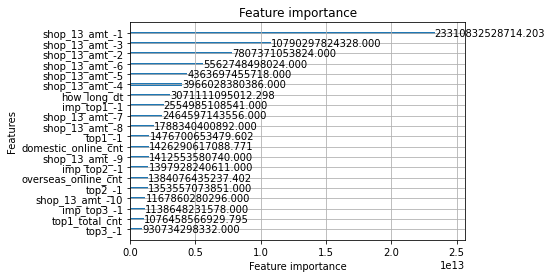

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.82583e+07	valid_1's l2: 1.8488e+07
[100]	training's l2: 1.56405e+07	valid_1's l2: 1.61088e+07
[150]	training's l2: 1.43356e+07	valid_1's l2: 1.5055e+07
[200]	training's l2: 1.35891e+07	valid_1's l2: 1.45628e+07
[250]	training's l2: 1.31052e+07	valid_1's l2: 1.43341e+07
[300]	training's l2: 1.274e+07	valid_1's l2: 1.4216e+07
[350]	training's l2: 1.24401e+07	valid_1's l2: 1.41524e+07
[400]	training's l2: 1.2175e+07	valid_1's l2: 1.41125e+07
[450]	training's l2: 1.19336e+07	valid_1's l2: 1.40869e+07
[500]	training's l2: 1.1715e+07	valid_1's l2: 1.4072e+07
[550]	training's l2: 1.15132e+07	valid_1's l2: 1.40588e+07
[600]	training's l2: 1.1319e+07	valid_1's l2: 1.40499e+07
[650]	training's l2: 1.11391e+07	valid_1's l2: 1.40435e+07
[700]	training's l2: 1.09628e+07	valid_1's l2: 1.40378e+07
[750]	training's l2: 1.07972e+07	valid_1's l2: 1.40339e+07
[800]	training's l2: 1.06404e+07	valid_1's l2: 1.403e+07
[850]	

<Figure size 864x432 with 0 Axes>

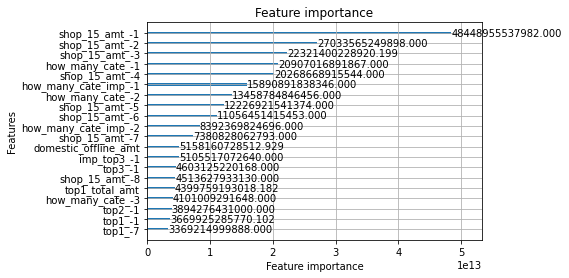

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.8221e+06	valid_1's l2: 7.977e+06
[100]	training's l2: 7.34924e+06	valid_1's l2: 7.6196e+06
[150]	training's l2: 7.05435e+06	valid_1's l2: 7.43636e+06
[200]	training's l2: 6.84611e+06	valid_1's l2: 7.33836e+06
[250]	training's l2: 6.68623e+06	valid_1's l2: 7.28532e+06
[300]	training's l2: 6.54873e+06	valid_1's l2: 7.25315e+06
[350]	training's l2: 6.43001e+06	valid_1's l2: 7.23454e+06
[400]	training's l2: 6.32413e+06	valid_1's l2: 7.22215e+06
[450]	training's l2: 6.22551e+06	valid_1's l2: 7.2144e+06
[500]	training's l2: 6.1331e+06	valid_1's l2: 7.20956e+06
[550]	training's l2: 6.04757e+06	valid_1's l2: 7.20598e+06
[600]	training's l2: 5.96557e+06	valid_1's l2: 7.20326e+06
[650]	training's l2: 5.88862e+06	valid_1's l2: 7.20176e+06
[700]	training's l2: 5.81187e+06	valid_1's l2: 7.2003e+06
[750]	training's l2: 5.74083e+06	valid_1's l2: 7.19937e+06
[800]	training's l2: 5.67211e+06	valid_1's l2: 7.19914e+06
[8

<Figure size 864x432 with 0 Axes>

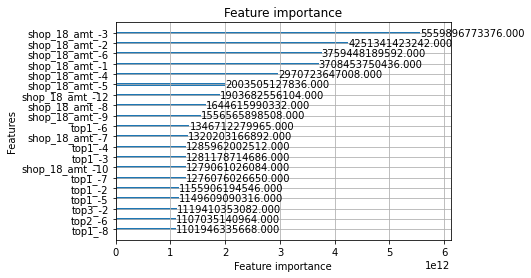

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.4283e+07	valid_1's l2: 1.44125e+07
[100]	training's l2: 1.336e+07	valid_1's l2: 1.37336e+07
[150]	training's l2: 1.27805e+07	valid_1's l2: 1.34003e+07
[200]	training's l2: 1.23773e+07	valid_1's l2: 1.32295e+07
[250]	training's l2: 1.20535e+07	valid_1's l2: 1.31357e+07
[300]	training's l2: 1.17851e+07	valid_1's l2: 1.30829e+07
[350]	training's l2: 1.15473e+07	valid_1's l2: 1.30496e+07
[400]	training's l2: 1.13282e+07	valid_1's l2: 1.30288e+07
[450]	training's l2: 1.1123e+07	valid_1's l2: 1.30142e+07
[500]	training's l2: 1.09359e+07	valid_1's l2: 1.30049e+07
[550]	training's l2: 1.07542e+07	valid_1's l2: 1.29978e+07
[600]	training's l2: 1.05874e+07	valid_1's l2: 1.29947e+07
[650]	training's l2: 1.04248e+07	valid_1's l2: 1.2992e+07
[700]	training's l2: 1.02706e+07	valid_1's l2: 1.29908e+07
[750]	training's l2: 1.01247e+07	valid_1's l2: 1.29903e+07
[800]	training's l2: 9.98294e+06	valid_1's l2: 1.29902e+07


<Figure size 864x432 with 0 Axes>

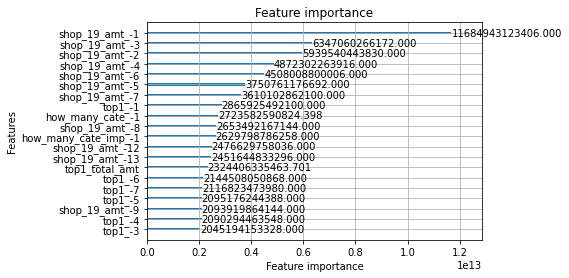

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.48217e+06	valid_1's l2: 8.43609e+06
[100]	training's l2: 8.13704e+06	valid_1's l2: 8.23745e+06
[150]	training's l2: 7.8946e+06	valid_1's l2: 8.13623e+06
[200]	training's l2: 7.70631e+06	valid_1's l2: 8.08115e+06
[250]	training's l2: 7.5486e+06	valid_1's l2: 8.05097e+06
[300]	training's l2: 7.41103e+06	valid_1's l2: 8.03321e+06
[350]	training's l2: 7.28347e+06	valid_1's l2: 8.02155e+06
[400]	training's l2: 7.16596e+06	valid_1's l2: 8.01312e+06
[450]	training's l2: 7.05681e+06	valid_1's l2: 8.00772e+06
[500]	training's l2: 6.95121e+06	valid_1's l2: 8.00499e+06
[550]	training's l2: 6.85278e+06	valid_1's l2: 8.00386e+06
[600]	training's l2: 6.75714e+06	valid_1's l2: 8.00218e+06
[650]	training's l2: 6.66407e+06	valid_1's l2: 8.00151e+06
[700]	training's l2: 6.57102e+06	valid_1's l2: 8.00134e+06
[750]	training's l2: 6.48494e+06	valid_1's l2: 8.00136e+06
[800]	training's l2: 6.39694e+06	valid_1's l2: 8.00182e+

<Figure size 864x432 with 0 Axes>

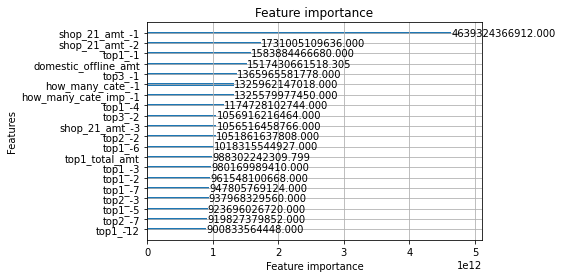

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.60158e+06	valid_1's l2: 2.60548e+06
[100]	training's l2: 2.38189e+06	valid_1's l2: 2.41886e+06
[150]	training's l2: 2.25564e+06	valid_1's l2: 2.32377e+06
[200]	training's l2: 2.17737e+06	valid_1's l2: 2.27586e+06
[250]	training's l2: 2.12063e+06	valid_1's l2: 2.2496e+06
[300]	training's l2: 2.07539e+06	valid_1's l2: 2.23522e+06
[350]	training's l2: 2.03722e+06	valid_1's l2: 2.22677e+06
[400]	training's l2: 2.00156e+06	valid_1's l2: 2.22137e+06
[450]	training's l2: 1.96975e+06	valid_1's l2: 2.21779e+06
[500]	training's l2: 1.94005e+06	valid_1's l2: 2.21539e+06
[550]	training's l2: 1.91419e+06	valid_1's l2: 2.21388e+06
[600]	training's l2: 1.88818e+06	valid_1's l2: 2.21276e+06
[650]	training's l2: 1.86388e+06	valid_1's l2: 2.21191e+06
[700]	training's l2: 1.84038e+06	valid_1's l2: 2.21136e+06
[750]	training's l2: 1.81796e+06	valid_1's l2: 2.21073e+06
[800]	training's l2: 1.79638e+06	valid_1's l2: 2.21032e

<Figure size 864x432 with 0 Axes>

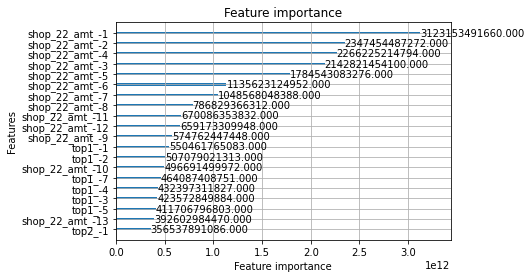

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.12207e+06	valid_1's l2: 4.17615e+06
[100]	training's l2: 3.79034e+06	valid_1's l2: 3.90702e+06
[150]	training's l2: 3.59945e+06	valid_1's l2: 3.77724e+06
[200]	training's l2: 3.4721e+06	valid_1's l2: 3.71053e+06
[250]	training's l2: 3.37589e+06	valid_1's l2: 3.67259e+06
[300]	training's l2: 3.30056e+06	valid_1's l2: 3.65382e+06
[350]	training's l2: 3.23585e+06	valid_1's l2: 3.6431e+06
[400]	training's l2: 3.17725e+06	valid_1's l2: 3.63653e+06
[450]	training's l2: 3.12338e+06	valid_1's l2: 3.63243e+06
[500]	training's l2: 3.07244e+06	valid_1's l2: 3.6301e+06
[550]	training's l2: 3.02401e+06	valid_1's l2: 3.62889e+06
[600]	training's l2: 2.97644e+06	valid_1's l2: 3.62818e+06
[650]	training's l2: 2.93253e+06	valid_1's l2: 3.62766e+06
[700]	training's l2: 2.89137e+06	valid_1's l2: 3.62731e+06
[750]	training's l2: 2.85098e+06	valid_1's l2: 3.62748e+06
[800]	training's l2: 2.81429e+06	valid_1's l2: 3.62743e+0

<Figure size 864x432 with 0 Axes>

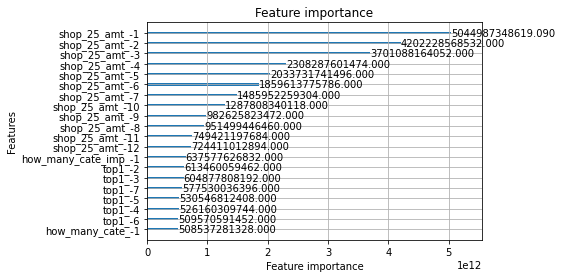

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.14974e+07	valid_1's l2: 1.15878e+07
[100]	training's l2: 1.10055e+07	valid_1's l2: 1.12446e+07
[150]	training's l2: 1.06893e+07	valid_1's l2: 1.10717e+07
[200]	training's l2: 1.04587e+07	valid_1's l2: 1.09819e+07
[250]	training's l2: 1.02761e+07	valid_1's l2: 1.09314e+07
[300]	training's l2: 1.01101e+07	valid_1's l2: 1.08999e+07
[350]	training's l2: 9.9576e+06	valid_1's l2: 1.08815e+07
[400]	training's l2: 9.81801e+06	valid_1's l2: 1.087e+07
[450]	training's l2: 9.68847e+06	valid_1's l2: 1.08611e+07
[500]	training's l2: 9.56771e+06	valid_1's l2: 1.08552e+07
[550]	training's l2: 9.4476e+06	valid_1's l2: 1.08512e+07
[600]	training's l2: 9.32822e+06	valid_1's l2: 1.08482e+07
[650]	training's l2: 9.21447e+06	valid_1's l2: 1.08449e+07
[700]	training's l2: 9.10219e+06	valid_1's l2: 1.08432e+07
[750]	training's l2: 8.9926e+06	valid_1's l2: 1.08424e+07
[800]	training's l2: 8.88695e+06	valid_1's l2: 1.08418e+07


<Figure size 864x432 with 0 Axes>

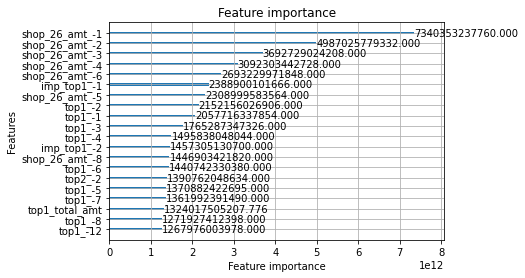

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.26815e+06	valid_1's l2: 8.49913e+06
[100]	training's l2: 6.37007e+06	valid_1's l2: 6.66466e+06
[150]	training's l2: 5.47331e+06	valid_1's l2: 5.83902e+06
[200]	training's l2: 5.03589e+06	valid_1's l2: 5.47902e+06
[250]	training's l2: 4.79116e+06	valid_1's l2: 5.31419e+06
[300]	training's l2: 4.63139e+06	valid_1's l2: 5.23705e+06
[350]	training's l2: 4.50082e+06	valid_1's l2: 5.18557e+06
[400]	training's l2: 4.39727e+06	valid_1's l2: 5.16117e+06
[450]	training's l2: 4.30514e+06	valid_1's l2: 5.14277e+06
[500]	training's l2: 4.22107e+06	valid_1's l2: 5.13218e+06
[550]	training's l2: 4.14235e+06	valid_1's l2: 5.12234e+06
[600]	training's l2: 4.066e+06	valid_1's l2: 5.11502e+06
[650]	training's l2: 3.99482e+06	valid_1's l2: 5.109e+06
[700]	training's l2: 3.93003e+06	valid_1's l2: 5.10496e+06
[750]	training's l2: 3.86338e+06	valid_1's l2: 5.10237e+06
[800]	training's l2: 3.80194e+06	valid_1's l2: 5.10029e+06

<Figure size 864x432 with 0 Axes>

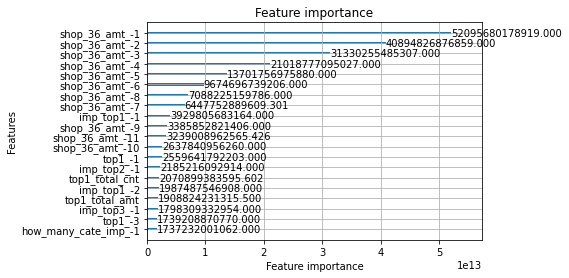

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.45371e+07	valid_1's l2: 2.47902e+07
[100]	training's l2: 2.0473e+07	valid_1's l2: 2.09726e+07
[150]	training's l2: 1.85639e+07	valid_1's l2: 1.93344e+07
[200]	training's l2: 1.75542e+07	valid_1's l2: 1.86089e+07
[250]	training's l2: 1.69268e+07	valid_1's l2: 1.82681e+07
[300]	training's l2: 1.64815e+07	valid_1's l2: 1.81035e+07
[350]	training's l2: 1.61205e+07	valid_1's l2: 1.80143e+07
[400]	training's l2: 1.58065e+07	valid_1's l2: 1.79576e+07
[450]	training's l2: 1.55196e+07	valid_1's l2: 1.79214e+07
[500]	training's l2: 1.52626e+07	valid_1's l2: 1.78994e+07
[550]	training's l2: 1.50171e+07	valid_1's l2: 1.78827e+07
[600]	training's l2: 1.47857e+07	valid_1's l2: 1.7871e+07
[650]	training's l2: 1.45646e+07	valid_1's l2: 1.78617e+07
[700]	training's l2: 1.43628e+07	valid_1's l2: 1.78551e+07
[750]	training's l2: 1.41615e+07	valid_1's l2: 1.78486e+07
[800]	training's l2: 1.39772e+07	valid_1's l2: 1.78448e+

<Figure size 864x432 with 0 Axes>

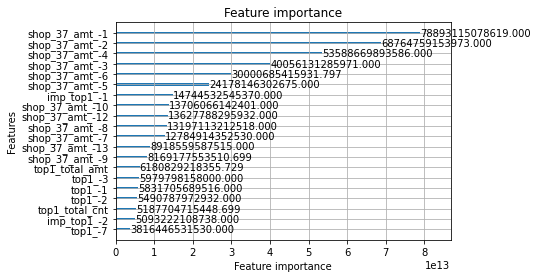

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.04168e+07	valid_1's l2: 1.04876e+07
[100]	training's l2: 9.88958e+06	valid_1's l2: 1.0139e+07
[150]	training's l2: 9.53403e+06	valid_1's l2: 9.95647e+06
[200]	training's l2: 9.27687e+06	valid_1's l2: 9.86023e+06
[250]	training's l2: 9.07377e+06	valid_1's l2: 9.80583e+06
[300]	training's l2: 8.90016e+06	valid_1's l2: 9.77345e+06
[350]	training's l2: 8.74662e+06	valid_1's l2: 9.75453e+06
[400]	training's l2: 8.60593e+06	valid_1's l2: 9.74155e+06
[450]	training's l2: 8.47776e+06	valid_1's l2: 9.73336e+06
[500]	training's l2: 8.35419e+06	valid_1's l2: 9.72772e+06
[550]	training's l2: 8.23901e+06	valid_1's l2: 9.72332e+06
[600]	training's l2: 8.1272e+06	valid_1's l2: 9.71979e+06
[650]	training's l2: 8.02611e+06	valid_1's l2: 9.71703e+06
[700]	training's l2: 7.93167e+06	valid_1's l2: 9.71543e+06
[750]	training's l2: 7.83114e+06	valid_1's l2: 9.71429e+06
[800]	training's l2: 7.73705e+06	valid_1's l2: 9.71434e+

<Figure size 864x432 with 0 Axes>

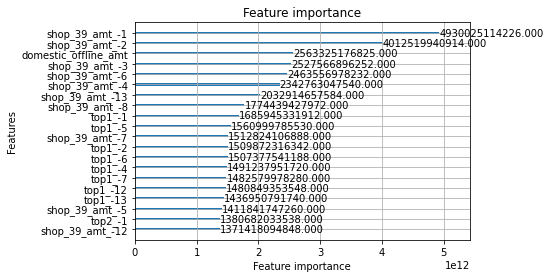

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.13142e+06	valid_1's l2: 9.26656e+06
[100]	training's l2: 7.66009e+06	valid_1's l2: 7.88393e+06
[150]	training's l2: 6.92935e+06	valid_1's l2: 7.25557e+06
[200]	training's l2: 6.53149e+06	valid_1's l2: 6.96759e+06
[250]	training's l2: 6.28463e+06	valid_1's l2: 6.83253e+06
[300]	training's l2: 6.10281e+06	valid_1's l2: 6.76416e+06
[350]	training's l2: 5.95805e+06	valid_1's l2: 6.72898e+06
[400]	training's l2: 5.83063e+06	valid_1's l2: 6.70962e+06
[450]	training's l2: 5.71708e+06	valid_1's l2: 6.69688e+06
[500]	training's l2: 5.61276e+06	valid_1's l2: 6.68767e+06
[550]	training's l2: 5.51565e+06	valid_1's l2: 6.68162e+06
[600]	training's l2: 5.42351e+06	valid_1's l2: 6.67704e+06
[650]	training's l2: 5.33492e+06	valid_1's l2: 6.67367e+06
[700]	training's l2: 5.25083e+06	valid_1's l2: 6.67059e+06
[750]	training's l2: 5.17377e+06	valid_1's l2: 6.66823e+06
[800]	training's l2: 5.09641e+06	valid_1's l2: 6.66634

<Figure size 864x432 with 0 Axes>

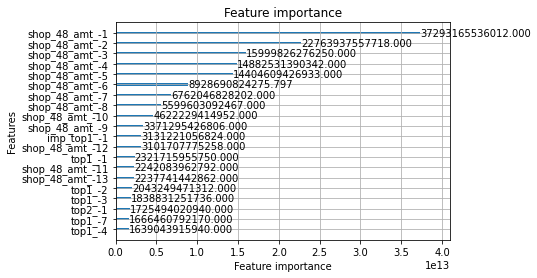

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.00111e+07	valid_1's l2: 2.99449e+07
[100]	training's l2: 2.69353e+07	valid_1's l2: 2.73892e+07
[150]	training's l2: 2.52679e+07	valid_1's l2: 2.62186e+07
[200]	training's l2: 2.42553e+07	valid_1's l2: 2.56743e+07
[250]	training's l2: 2.35495e+07	valid_1's l2: 2.54213e+07
[300]	training's l2: 2.29913e+07	valid_1's l2: 2.52909e+07
[350]	training's l2: 2.25189e+07	valid_1's l2: 2.52227e+07
[400]	training's l2: 2.21007e+07	valid_1's l2: 2.51828e+07
[450]	training's l2: 2.17211e+07	valid_1's l2: 2.51588e+07
[500]	training's l2: 2.13864e+07	valid_1's l2: 2.51419e+07
[550]	training's l2: 2.10627e+07	valid_1's l2: 2.51302e+07
[600]	training's l2: 2.07596e+07	valid_1's l2: 2.51223e+07
[650]	training's l2: 2.04618e+07	valid_1's l2: 2.51149e+07
[700]	training's l2: 2.0185e+07	valid_1's l2: 2.51101e+07
[750]	training's l2: 1.9925e+07	valid_1's l2: 2.51071e+07
[800]	training's l2: 1.96647e+07	valid_1

<Figure size 864x432 with 0 Axes>

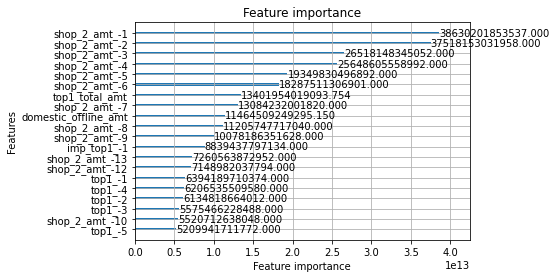

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.03284e+06	valid_1's l2: 7.10033e+06
[100]	training's l2: 6.30109e+06	valid_1's l2: 6.48864e+06
[150]	training's l2: 5.91156e+06	valid_1's l2: 6.20521e+06
[200]	training's l2: 5.68367e+06	valid_1's l2: 6.0743e+06
[250]	training's l2: 5.52954e+06	valid_1's l2: 6.0084e+06
[300]	training's l2: 5.41264e+06	valid_1's l2: 5.97396e+06
[350]	training's l2: 5.31877e+06	valid_1's l2: 5.9597e+06
[400]	training's l2: 5.23168e+06	valid_1's l2: 5.94897e+06
[450]	training's l2: 5.1527e+06	valid_1's l2: 5.94299e+06
[500]	training's l2: 5.07687e+06	valid_1's l2: 5.93813e+06
[550]	training's l2: 5.00819e+06	valid_1's l2: 5.93576e+06
[600]	training's l2: 4.93876e+06	valid_1's l2: 5.93358e+06
[650]	training's l2: 4.87448e+06	valid_1's l2: 5.9323e+06
[700]	training's l2: 4.8129e+06	valid_1's l2: 5.93123e+06
[750]	training's l2: 4.75141e+06	valid_1's l2: 5.93105e+06
[800]	training's l2: 4.69269e+06	valid_1's l2: 5.93055e+06
[

<Figure size 864x432 with 0 Axes>

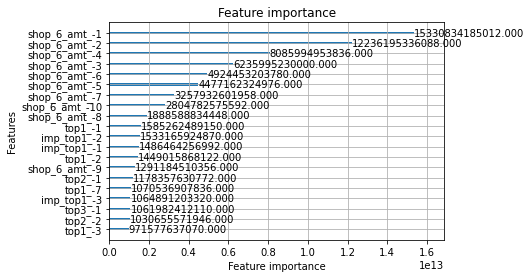

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.37349e+07	valid_1's l2: 2.39343e+07
[100]	training's l2: 2.05958e+07	valid_1's l2: 2.11297e+07
[150]	training's l2: 1.89887e+07	valid_1's l2: 1.98569e+07
[200]	training's l2: 1.80407e+07	valid_1's l2: 1.9243e+07
[250]	training's l2: 1.7424e+07	valid_1's l2: 1.89516e+07
[300]	training's l2: 1.69426e+07	valid_1's l2: 1.87943e+07
[350]	training's l2: 1.65359e+07	valid_1's l2: 1.86952e+07
[400]	training's l2: 1.61784e+07	valid_1's l2: 1.86338e+07
[450]	training's l2: 1.58584e+07	valid_1's l2: 1.85951e+07
[500]	training's l2: 1.55581e+07	valid_1's l2: 1.85641e+07
[550]	training's l2: 1.52809e+07	valid_1's l2: 1.85434e+07
[600]	training's l2: 1.50112e+07	valid_1's l2: 1.85242e+07
[650]	training's l2: 1.4759e+07	valid_1's l2: 1.85059e+07
[700]	training's l2: 1.45148e+07	valid_1's l2: 1.84937e+07
[750]	training's l2: 1.42874e+07	valid_1's l2: 1.84867e+07
[800]	training's l2: 1.40611e+07	valid_1's l2: 1.84802e+0

<Figure size 864x432 with 0 Axes>

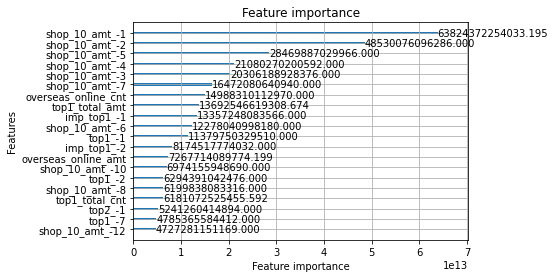

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.65694e+06	valid_1's l2: 9.54101e+06
[100]	training's l2: 8.80616e+06	valid_1's l2: 8.80891e+06
[150]	training's l2: 8.34732e+06	valid_1's l2: 8.47008e+06
[200]	training's l2: 8.06589e+06	valid_1's l2: 8.30852e+06
[250]	training's l2: 7.86498e+06	valid_1's l2: 8.22403e+06
[300]	training's l2: 7.70723e+06	valid_1's l2: 8.17854e+06
[350]	training's l2: 7.57194e+06	valid_1's l2: 8.15321e+06
[400]	training's l2: 7.44939e+06	valid_1's l2: 8.13704e+06
[450]	training's l2: 7.33337e+06	valid_1's l2: 8.12598e+06
[500]	training's l2: 7.22666e+06	valid_1's l2: 8.11981e+06
[550]	training's l2: 7.12638e+06	valid_1's l2: 8.11456e+06
[600]	training's l2: 7.0285e+06	valid_1's l2: 8.11069e+06
[650]	training's l2: 6.93325e+06	valid_1's l2: 8.1082e+06
[700]	training's l2: 6.83998e+06	valid_1's l2: 8.10581e+06
[750]	training's l2: 6.75292e+06	valid_1's l2: 8.10434e+06
[800]	training's l2: 6.66771e+06	valid_1's l2: 8.10415e+

<Figure size 864x432 with 0 Axes>

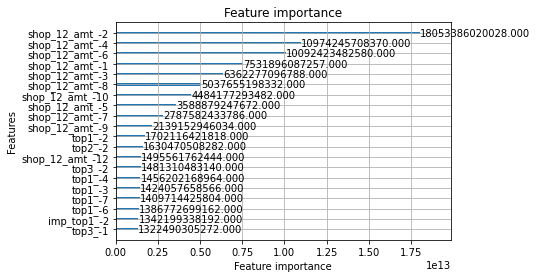

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.52611e+06	valid_1's l2: 3.52308e+06
[100]	training's l2: 2.81649e+06	valid_1's l2: 2.86537e+06
[150]	training's l2: 2.4529e+06	valid_1's l2: 2.54796e+06
[200]	training's l2: 2.25881e+06	valid_1's l2: 2.39604e+06
[250]	training's l2: 2.13231e+06	valid_1's l2: 2.30804e+06
[300]	training's l2: 2.04359e+06	valid_1's l2: 2.2547e+06
[350]	training's l2: 1.97875e+06	valid_1's l2: 2.22498e+06
[400]	training's l2: 1.92061e+06	valid_1's l2: 2.19965e+06
[450]	training's l2: 1.87022e+06	valid_1's l2: 2.17939e+06
[500]	training's l2: 1.82264e+06	valid_1's l2: 2.16029e+06
[550]	training's l2: 1.78204e+06	valid_1's l2: 2.14709e+06
[600]	training's l2: 1.74521e+06	valid_1's l2: 2.13711e+06
[650]	training's l2: 1.71123e+06	valid_1's l2: 2.12899e+06
[700]	training's l2: 1.67932e+06	valid_1's l2: 2.12088e+06
[750]	training's l2: 1.65053e+06	valid_1's l2: 2.11538e+06
[800]	training's l2: 1.62064e+06	valid_1's l2: 2.10879e+

<Figure size 864x432 with 0 Axes>

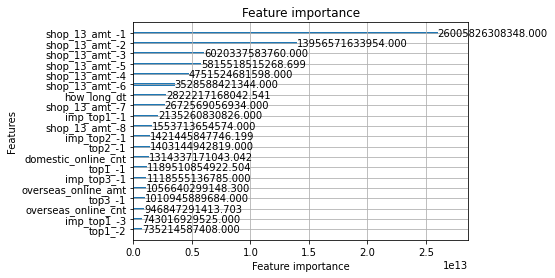

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.83343e+07	valid_1's l2: 1.83279e+07
[100]	training's l2: 1.56773e+07	valid_1's l2: 1.59278e+07
[150]	training's l2: 1.43833e+07	valid_1's l2: 1.48995e+07
[200]	training's l2: 1.36437e+07	valid_1's l2: 1.44228e+07
[250]	training's l2: 1.31572e+07	valid_1's l2: 1.41905e+07
[300]	training's l2: 1.27888e+07	valid_1's l2: 1.40695e+07
[350]	training's l2: 1.24845e+07	valid_1's l2: 1.40035e+07
[400]	training's l2: 1.22177e+07	valid_1's l2: 1.3961e+07
[450]	training's l2: 1.19787e+07	valid_1's l2: 1.39361e+07
[500]	training's l2: 1.1758e+07	valid_1's l2: 1.39183e+07
[550]	training's l2: 1.15508e+07	valid_1's l2: 1.39049e+07
[600]	training's l2: 1.13571e+07	valid_1's l2: 1.38962e+07
[650]	training's l2: 1.11775e+07	valid_1's l2: 1.38887e+07
[700]	training's l2: 1.10021e+07	valid_1's l2: 1.38838e+07
[750]	training's l2: 1.08325e+07	valid_1's l2: 1.38788e+07
[800]	training's l2: 1.0664e+07	valid_1's l2: 1.38757e+0

<Figure size 864x432 with 0 Axes>

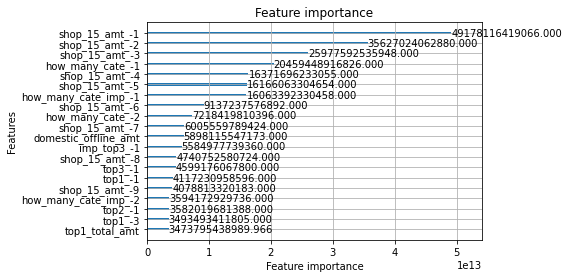

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.88908e+06	valid_1's l2: 7.85303e+06
[100]	training's l2: 7.4015e+06	valid_1's l2: 7.49564e+06
[150]	training's l2: 7.10054e+06	valid_1's l2: 7.3168e+06
[200]	training's l2: 6.88992e+06	valid_1's l2: 7.22265e+06
[250]	training's l2: 6.72753e+06	valid_1's l2: 7.16884e+06
[300]	training's l2: 6.59267e+06	valid_1's l2: 7.13973e+06
[350]	training's l2: 6.4755e+06	valid_1's l2: 7.12304e+06
[400]	training's l2: 6.36766e+06	valid_1's l2: 7.11231e+06
[450]	training's l2: 6.26878e+06	valid_1's l2: 7.10642e+06
[500]	training's l2: 6.17701e+06	valid_1's l2: 7.10245e+06
[550]	training's l2: 6.09194e+06	valid_1's l2: 7.10118e+06
[600]	training's l2: 6.00895e+06	valid_1's l2: 7.09929e+06
[650]	training's l2: 5.9262e+06	valid_1's l2: 7.09832e+06
[700]	training's l2: 5.85284e+06	valid_1's l2: 7.09835e+06
[750]	training's l2: 5.77868e+06	valid_1's l2: 7.09888e+06
Early stopping, best iteration is:
[675]	training's l2: 5.

<Figure size 864x432 with 0 Axes>

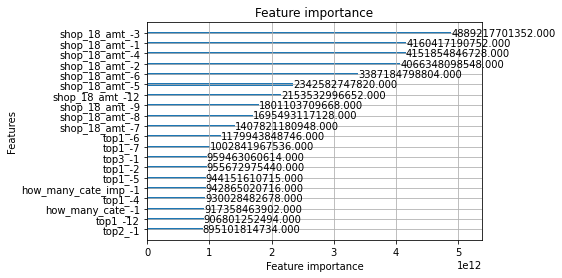

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.41595e+07	valid_1's l2: 1.46504e+07
[100]	training's l2: 1.32599e+07	valid_1's l2: 1.39808e+07
[150]	training's l2: 1.26843e+07	valid_1's l2: 1.36396e+07
[200]	training's l2: 1.22772e+07	valid_1's l2: 1.34586e+07
[250]	training's l2: 1.19609e+07	valid_1's l2: 1.33592e+07
[300]	training's l2: 1.1692e+07	valid_1's l2: 1.3302e+07
[350]	training's l2: 1.145e+07	valid_1's l2: 1.32661e+07
[400]	training's l2: 1.12285e+07	valid_1's l2: 1.32432e+07
[450]	training's l2: 1.1025e+07	valid_1's l2: 1.32283e+07
[500]	training's l2: 1.0835e+07	valid_1's l2: 1.32166e+07
[550]	training's l2: 1.06567e+07	valid_1's l2: 1.32096e+07
[600]	training's l2: 1.04879e+07	valid_1's l2: 1.32039e+07
[650]	training's l2: 1.03262e+07	valid_1's l2: 1.31993e+07
[700]	training's l2: 1.01681e+07	valid_1's l2: 1.31959e+07
[750]	training's l2: 1.00178e+07	valid_1's l2: 1.31938e+07
[800]	training's l2: 9.87491e+06	valid_1's l2: 1.31936e+07
[

<Figure size 864x432 with 0 Axes>

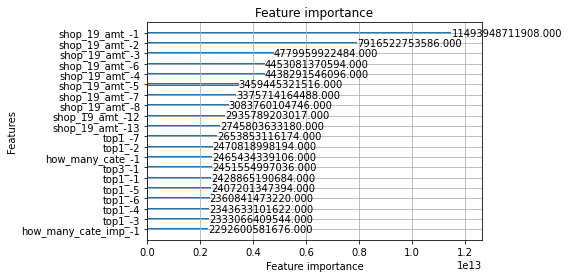

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.45249e+06	valid_1's l2: 8.50319e+06
[100]	training's l2: 8.11177e+06	valid_1's l2: 8.30254e+06
[150]	training's l2: 7.86938e+06	valid_1's l2: 8.19651e+06
[200]	training's l2: 7.68327e+06	valid_1's l2: 8.14103e+06
[250]	training's l2: 7.52657e+06	valid_1's l2: 8.10906e+06
[300]	training's l2: 7.38823e+06	valid_1's l2: 8.08973e+06
[350]	training's l2: 7.26234e+06	valid_1's l2: 8.0778e+06
[400]	training's l2: 7.14538e+06	valid_1's l2: 8.07083e+06
[450]	training's l2: 7.03879e+06	valid_1's l2: 8.06513e+06
[500]	training's l2: 6.93521e+06	valid_1's l2: 8.06155e+06
[550]	training's l2: 6.83891e+06	valid_1's l2: 8.05876e+06
[600]	training's l2: 6.74341e+06	valid_1's l2: 8.05803e+06
[650]	training's l2: 6.65428e+06	valid_1's l2: 8.0579e+06
[700]	training's l2: 6.56831e+06	valid_1's l2: 8.05764e+06
[750]	training's l2: 6.48357e+06	valid_1's l2: 8.05783e+06
[800]	training's l2: 6.40041e+06	valid_1's l2: 8.05841e+

<Figure size 864x432 with 0 Axes>

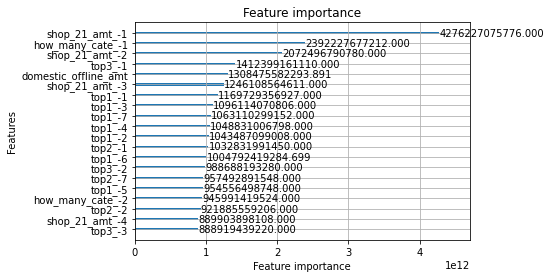

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.58722e+06	valid_1's l2: 2.60696e+06
[100]	training's l2: 2.37201e+06	valid_1's l2: 2.4253e+06
[150]	training's l2: 2.24944e+06	valid_1's l2: 2.33651e+06
[200]	training's l2: 2.17033e+06	valid_1's l2: 2.29016e+06
[250]	training's l2: 2.11198e+06	valid_1's l2: 2.26435e+06
[300]	training's l2: 2.06609e+06	valid_1's l2: 2.25139e+06
[350]	training's l2: 2.02619e+06	valid_1's l2: 2.24375e+06
[400]	training's l2: 1.99087e+06	valid_1's l2: 2.23922e+06
[450]	training's l2: 1.95977e+06	valid_1's l2: 2.2363e+06
[500]	training's l2: 1.93171e+06	valid_1's l2: 2.2344e+06
[550]	training's l2: 1.90411e+06	valid_1's l2: 2.23309e+06
[600]	training's l2: 1.87784e+06	valid_1's l2: 2.23232e+06
[650]	training's l2: 1.85408e+06	valid_1's l2: 2.23157e+06
[700]	training's l2: 1.83226e+06	valid_1's l2: 2.23118e+06
[750]	training's l2: 1.81035e+06	valid_1's l2: 2.23103e+06
[800]	training's l2: 1.78916e+06	valid_1's l2: 2.2307e+06

<Figure size 864x432 with 0 Axes>

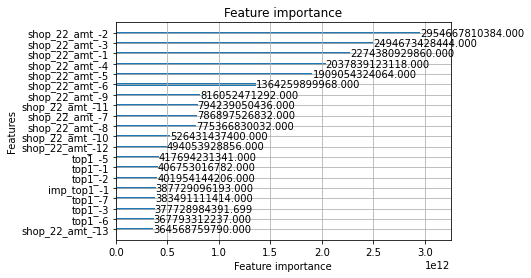

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.08155e+06	valid_1's l2: 4.27116e+06
[100]	training's l2: 3.7589e+06	valid_1's l2: 3.99435e+06
[150]	training's l2: 3.56682e+06	valid_1's l2: 3.85225e+06
[200]	training's l2: 3.44402e+06	valid_1's l2: 3.78163e+06
[250]	training's l2: 3.3509e+06	valid_1's l2: 3.74187e+06
[300]	training's l2: 3.27583e+06	valid_1's l2: 3.71978e+06
[350]	training's l2: 3.21067e+06	valid_1's l2: 3.70703e+06
[400]	training's l2: 3.15307e+06	valid_1's l2: 3.69859e+06
[450]	training's l2: 3.0991e+06	valid_1's l2: 3.69338e+06
[500]	training's l2: 3.04953e+06	valid_1's l2: 3.68966e+06
[550]	training's l2: 3.00157e+06	valid_1's l2: 3.68795e+06
[600]	training's l2: 2.95759e+06	valid_1's l2: 3.68655e+06
[650]	training's l2: 2.91497e+06	valid_1's l2: 3.68489e+06
[700]	training's l2: 2.87396e+06	valid_1's l2: 3.68401e+06
[750]	training's l2: 2.83608e+06	valid_1's l2: 3.68339e+06
[800]	training's l2: 2.79618e+06	valid_1's l2: 3.68276e+0

<Figure size 864x432 with 0 Axes>

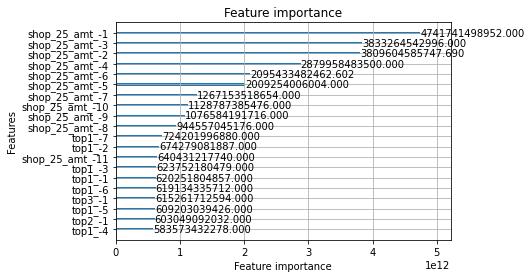

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.15756e+07	valid_1's l2: 1.13804e+07
[100]	training's l2: 1.10936e+07	valid_1's l2: 1.10658e+07
[150]	training's l2: 1.07692e+07	valid_1's l2: 1.09007e+07
[200]	training's l2: 1.05365e+07	valid_1's l2: 1.08218e+07
[250]	training's l2: 1.03439e+07	valid_1's l2: 1.0777e+07
[300]	training's l2: 1.01821e+07	valid_1's l2: 1.07526e+07
[350]	training's l2: 1.00307e+07	valid_1's l2: 1.07375e+07
[400]	training's l2: 9.88929e+06	valid_1's l2: 1.07286e+07
[450]	training's l2: 9.76096e+06	valid_1's l2: 1.07238e+07
[500]	training's l2: 9.63501e+06	valid_1's l2: 1.07212e+07
[550]	training's l2: 9.51829e+06	valid_1's l2: 1.07193e+07
[600]	training's l2: 9.40653e+06	valid_1's l2: 1.07176e+07
[650]	training's l2: 9.29769e+06	valid_1's l2: 1.07166e+07
[700]	training's l2: 9.19528e+06	valid_1's l2: 1.07176e+07
Early stopping, best iteration is:
[647]	training's l2: 9.30454e+06	valid_1's l2: 1.07165e+07


<Figure size 864x432 with 0 Axes>

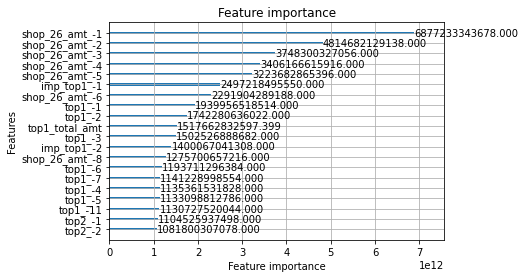

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 8.34095e+06	valid_1's l2: 8.39852e+06
[100]	training's l2: 6.4025e+06	valid_1's l2: 6.53151e+06
[150]	training's l2: 5.51685e+06	valid_1's l2: 5.72106e+06
[200]	training's l2: 5.09213e+06	valid_1's l2: 5.37903e+06
[250]	training's l2: 4.83847e+06	valid_1's l2: 5.20923e+06
[300]	training's l2: 4.67003e+06	valid_1's l2: 5.12257e+06
[350]	training's l2: 4.54469e+06	valid_1's l2: 5.07771e+06
[400]	training's l2: 4.43888e+06	valid_1's l2: 5.05165e+06
[450]	training's l2: 4.34588e+06	valid_1's l2: 5.03512e+06
[500]	training's l2: 4.26096e+06	valid_1's l2: 5.02319e+06
[550]	training's l2: 4.18171e+06	valid_1's l2: 5.01509e+06
[600]	training's l2: 4.11035e+06	valid_1's l2: 5.01049e+06
[650]	training's l2: 4.03774e+06	valid_1's l2: 5.00546e+06
[700]	training's l2: 3.97275e+06	valid_1's l2: 5.00237e+06
[750]	training's l2: 3.90804e+06	valid_1's l2: 4.9991e+06
[800]	training's l2: 3.84533e+06	valid_1's l2: 4.99676e+

<Figure size 864x432 with 0 Axes>

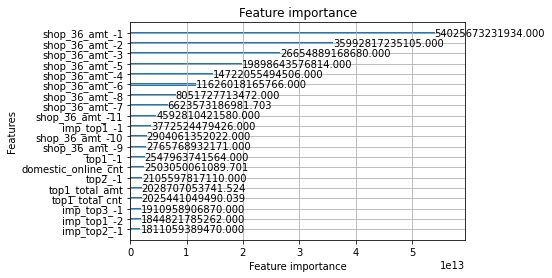

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.46286e+07	valid_1's l2: 2.50135e+07
[100]	training's l2: 2.05015e+07	valid_1's l2: 2.11668e+07
[150]	training's l2: 1.85519e+07	valid_1's l2: 1.95046e+07
[200]	training's l2: 1.7528e+07	valid_1's l2: 1.87728e+07
[250]	training's l2: 1.68887e+07	valid_1's l2: 1.84237e+07
[300]	training's l2: 1.64326e+07	valid_1's l2: 1.82504e+07
[350]	training's l2: 1.60657e+07	valid_1's l2: 1.81513e+07
[400]	training's l2: 1.57409e+07	valid_1's l2: 1.80909e+07
[450]	training's l2: 1.54632e+07	valid_1's l2: 1.806e+07
[500]	training's l2: 1.52058e+07	valid_1's l2: 1.80383e+07
[550]	training's l2: 1.49627e+07	valid_1's l2: 1.80226e+07
[600]	training's l2: 1.47374e+07	valid_1's l2: 1.8012e+07
[650]	training's l2: 1.4518e+07	valid_1's l2: 1.80029e+07
[700]	training's l2: 1.43171e+07	valid_1's l2: 1.7995e+07
[750]	training's l2: 1.41164e+07	valid_1's l2: 1.79901e+07
[800]	training's l2: 1.39254e+07	valid_1's l2: 1.79863e+07
[

<Figure size 864x432 with 0 Axes>

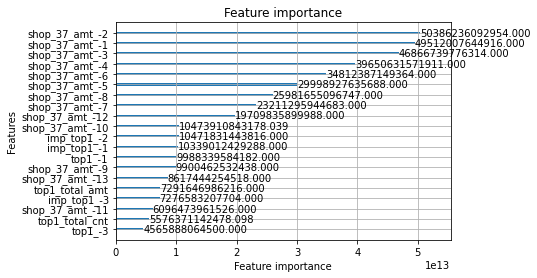

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 1.03877e+07	valid_1's l2: 1.05564e+07
[100]	training's l2: 9.86669e+06	valid_1's l2: 1.01992e+07
[150]	training's l2: 9.51633e+06	valid_1's l2: 1.00077e+07
[200]	training's l2: 9.26598e+06	valid_1's l2: 9.90989e+06
[250]	training's l2: 9.05926e+06	valid_1's l2: 9.85221e+06
[300]	training's l2: 8.8827e+06	valid_1's l2: 9.81452e+06
[350]	training's l2: 8.72431e+06	valid_1's l2: 9.79245e+06
[400]	training's l2: 8.58573e+06	valid_1's l2: 9.77659e+06
[450]	training's l2: 8.45586e+06	valid_1's l2: 9.76663e+06
[500]	training's l2: 8.33566e+06	valid_1's l2: 9.75954e+06
[550]	training's l2: 8.22502e+06	valid_1's l2: 9.75482e+06
[600]	training's l2: 8.11547e+06	valid_1's l2: 9.75009e+06
[650]	training's l2: 8.01338e+06	valid_1's l2: 9.74683e+06
[700]	training's l2: 7.9102e+06	valid_1's l2: 9.74504e+06
[750]	training's l2: 7.81277e+06	valid_1's l2: 9.74246e+06
[800]	training's l2: 7.71678e+06	valid_1's l2: 9.74086e+

<Figure size 864x432 with 0 Axes>

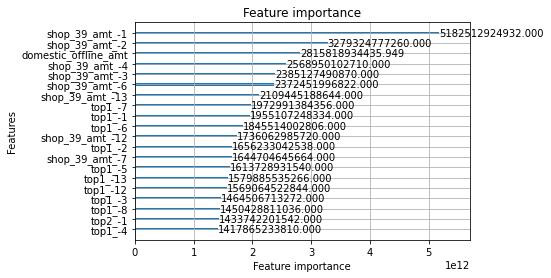

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 9.19621e+06	valid_1's l2: 9.28504e+06
[100]	training's l2: 7.69413e+06	valid_1's l2: 7.89625e+06
[150]	training's l2: 6.94743e+06	valid_1's l2: 7.26181e+06
[200]	training's l2: 6.54067e+06	valid_1's l2: 6.96933e+06
[250]	training's l2: 6.29733e+06	valid_1's l2: 6.84017e+06
[300]	training's l2: 6.11848e+06	valid_1's l2: 6.77308e+06
[350]	training's l2: 5.9749e+06	valid_1's l2: 6.7387e+06
[400]	training's l2: 5.8467e+06	valid_1's l2: 6.71614e+06
[450]	training's l2: 5.73279e+06	valid_1's l2: 6.70286e+06
[500]	training's l2: 5.62608e+06	valid_1's l2: 6.69395e+06
[550]	training's l2: 5.52394e+06	valid_1's l2: 6.6865e+06
[600]	training's l2: 5.43201e+06	valid_1's l2: 6.68156e+06
[650]	training's l2: 5.34029e+06	valid_1's l2: 6.67714e+06
[700]	training's l2: 5.25161e+06	valid_1's l2: 6.67372e+06
[750]	training's l2: 5.16771e+06	valid_1's l2: 6.67208e+06
[800]	training's l2: 5.08999e+06	valid_1's l2: 6.67069e+06

<Figure size 864x432 with 0 Axes>

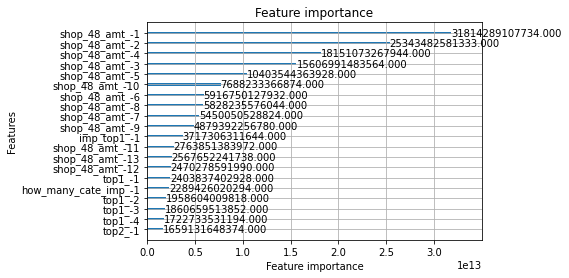

In [14]:
results = {a_cate: [] for a_cate in amt_handler.ylabels}
train_results = {a_cate: [] for a_cate in amt_handler.ylabels}
idx_results = []
for fold, (trn_ind, val_ind) in enumerate(kf.split(X)):
    idx_results.append((trn_ind, val_ind))
    print(f'Training fold {fold + 1}')
    for ylabel in amt_handler.ylabels:
        col_name = ylabel
        # test
        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(amt_test))
        results[ylabel].append(result)

In [15]:
loader.save_data([results, train_results, idx_results],
                 '2021_12_20_amt_train_results.joblib',
                 '2021_12_20 rerun generate_train_results')
